Preprocessing Code

In [2]:
'''This module ensures all models train and evaluate on the same data '''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.3 #leave 70% for training
VAL_SIZE = 0.50 #validation and test set should each be 15% of og dataset

# function to load dataset, default location set
def load_data(path="./bots_vs_users.csv"):
    df = pd.read_csv(path)
    return df

def preprocess(df):
    #all values in these columns are 1
    df = df.drop(columns=["has_short_name", "has_full_name", "city"], errors="ignore")

    # Preprocess the data by handling the empty cells and cells that contain "Unknown" as a value
    # Cannot drop empty cells because it is one of the signals indicating a bot account
    # Strategy: replace empty cells with NaN
    df.replace("",np.nan,inplace=True)

    # Identify numerical features
    num_cols = df.select_dtypes(include =['float64']).columns.tolist()

    # subscribers_count feature is supposed to be a numerical feature but has "Unknown" cells
    # strategy: convert "Uknown" to NaN and then append subscribers_count into numerical_cols
    df['subscribers_count'] = df['subscribers_count'].replace("Unknown",np.nan)
    df['subscribers_count'] = pd.to_numeric(df['subscribers_count'])
    num_cols.append('subscribers_count')

    # Categorical features are everything else except for the target feature
    cat_cols = [c for c in df.columns if c not in num_cols and c != "target"]

    # Add missingness indicators (in order to distinguish cells with actual values and empty cells)
    for col in num_cols:
        df[col+'_missing'] = df[col].isnull().astype(int)

    num_cols_with_indicator = num_cols + [col + '_missing' for col in num_cols]

    # Preprocessing Transformers
    # For numeric features, preprocess the data by median imputation (replace missing values with the median of the features)
    numeric_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'median'))
    ])

    # For categorical features use One Hot Encoding
    categorical_transformer = Pipeline(steps = [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ])
    # Combining everything into a singular preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols_with_indicator),
            ('cat', categorical_transformer, cat_cols)
        ],
        remainder='drop'
    )

    y = df["target"].astype("float32").values
    X_df = df.drop(columns=["target"])
    return X_df, y, preprocessor

def split(X, y, preprocessor, test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_SEED):
    #First split: 70% train, 30% temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,#keep class balance consistent
    )
    #Second split: split temp into 50/50 into 15% val, 15% test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size= val_size,
        random_state= random_state,
        stratify=y_temp,
    )
    X_train = preprocessor.fit_transform(X_train)
    X_val   = preprocessor.transform(X_val)
    X_test  = preprocessor.transform(X_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

XGBoost Code

In [ ]:

import pandas as pd
import numpy as np
import data_module
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report




# Get data from the preprocessing file
df = data_module.load_data()
X, y, preprocessor = data_module.preprocess(df)
X_train, y_train, X_val, y_val, X_test, y_test = data_module.split(X, y, preprocessor)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Setting up the hyperparameter grid for tuning
param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# We are using randomized search because it is faster than grid search
XGB_searched = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1,
    random_state=42
)

XGB_searched.fit(X_train, y_train)
print(f"Best parameters: {XGB_searched.best_params_}")

# Train Final Model
best_xgb_model = XGBClassifier(
    max_depth=XGB_searched.best_params_.get('max_depth'),
    learning_rate=XGB_searched.best_params_.get('learning_rate'),
    n_estimators=XGB_searched.best_params_.get('n_estimators'),
    objective='binary:logistic',
    booster='gbtree',
    tree_method='hist',
    n_jobs=-1,
    subsample=1,
    reg_alpha=1,
    scale_pos_weight=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_xgb_model.fit(X_train, y_train)


# Plot feature importances
feature_names = preprocessor.get_feature_names_out()

importances = best_xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20
top_indices = indices[:top_n]

f, ax = plt.subplots(figsize=(8, 8))
plt.title("Top 20 Most Important Variables for XGBoost")
sns.set_color_codes("bright")

sns.barplot(y=[feature_names[i] for i in top_indices],
            x=importances[top_indices],
            label="Total", color="b")

ax.set(ylabel="Variable", xlabel="Variable Importance")
sns.despine(left=True, bottom=True)
plt.show()



# Check for overfitting
train_pred = best_xgb_model.predict(X_train)
val_pred = best_xgb_model.predict(X_val)
test_pred = best_xgb_model.predict(X_test)
train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)
print("Check for overfitting")
print("Train Accuracy: ", train_acc)
print("Validation Accuracy: ", val_acc)
print("Test Accuracy: ", test_acc)



# Plot the ROC Curves
train_prob = best_xgb_model.predict_proba(X_train)[:, 1]
val_prob = best_xgb_model.predict_proba(X_val)[:, 1]
test_prob = best_xgb_model.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, train_prob)
val_auc = roc_auc_score(y_val, val_prob)
test_auc = roc_auc_score(y_test, test_prob)

plt.figure(figsize=(8, 6))
fpr_train, tpr_train, _ = roc_curve(y_train, train_prob)
plt.plot(fpr_train, tpr_train, linestyle='--', color='red', label=f'Train AUC = {train_auc:.3f}')
fpr_val, tpr_val, _ = roc_curve(y_val, val_prob)
plt.plot(fpr_val, tpr_val, linestyle='solid', color='blue', label=f'Validation AUC = {val_auc:.3f}')
fpr_test, tpr_test, _ = roc_curve(y_test, test_prob)
plt.plot(fpr_test, tpr_test, linestyle='dotted', color='green', label=f'Test AUC = {test_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc= "lower right")
plt.show()

# Plot metrics
print(classification_report(y_test, test_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, test_pred))


# Plotting Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, test_prob)
avg_precision = average_precision_score(y_test, test_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', lw=2, label=f'Average = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Logistic Regression Code

In [ ]:
# Users vs bots classification: Logistic Regression Model

#Import necessary libraries:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report)
import warnings
warnings.filterwarnings('ignore')
import data_module

df = data_module.load_data()
X, y, preprocessor = data_module.preprocess(df)
X_train, y_train, X_val, y_val, X_test, y_test = data_module.split(X, y, preprocessor)

df.head()

#Check basic stastics of the dataset
df.info()

logreg_classifier = LogisticRegression(max_iter=1000, random_state=42)
logreg_classifier.fit(X_train, y_train) # Train the model

#Acess feature's importance using coefficients
feature_names = preprocessor.get_feature_names_out()
coef = pd.Series(logreg_classifier.coef_[0], index=feature_names)
print(coef.sort_values(ascending=False))

"""## Evaluation"""

# Prediciton and evaluation for all models
models = {'Logistic Regression': logreg_classifier}

for model_name, model in models.items():
  ytrain_pred = model.predict(X_train)
  ytest_pred = model.predict(X_test)

  print(f"---{model_name}---")
  print("Test accuracy:", accuracy_score(y_test, ytest_pred))
  print("Precision:", precision_score(y_test, ytest_pred))
  print("Recall:", recall_score(y_test, ytest_pred))
  print("F1 score:", f1_score(y_test, ytest_pred))
  print("Confusion matrix:\n", confusion_matrix(y_test,ytest_pred))
  print("Classification Report: \n", classification_report(y_test,ytest_pred))

  #Calculate sensitivity and specificity
  # - True Positive: 1 predicted as 1
  # - True Negative: 0 predicted as 0
  # - False Positive: 1 predicted as 0
  # - False Negative: 0 predicted as 1
  tn, fp, fn, tp = confusion_matrix(y_test, ytest_pred).ravel()
  sensitivity = tp / (tp + fn) # recall
  specificity = tn / (tn + fp) # specificity
  print(f"Sensitivity (Recall) for {model_name}: {sensitivity:.4f}")
  print(f"Specificity for {model_name}: {specificity:.4f}")

  # Plot confusion matrix heatmap
  cm = confusion_matrix(y_test, ytest_pred)
  plt.figure()
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # ROC Curve and AUC
  ytest_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, ytest_prob)
  roc_auc = roc_auc_score(y_test, ytest_prob)

  plt.figure()
  plt.plot(fpr, tpr, label = f'{model_name} (AUROC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--',color = 'gray')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name}')
  plt.legend(loc = 'lower right')
  plt.show()

Neural Network Code

Samples: 5874, Features: 72


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │           158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158 (632.00 B)

 Trainable params: 158 (632.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6446 - auc: 0.7004 - loss: 0.6449 - val_accuracy: 0.9262 - val_auc: 0.9581 - val_loss: 0.2997
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9324 - auc: 0.9618 - loss: 0.2746 - val_accuracy: 0.9444 - val_auc: 0.9753 - val_loss: 0.1984
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9440 - auc: 0.9714 - loss: 0.2077 - val_accuracy: 0.9546 - val_auc: 0.9825 - val_loss: 0.1656
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9485 - auc: 0.9745 - loss: 0.1860 - val_accuracy: 0.9580 - val_auc: 0.9854 - val_loss: 0.1515
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - auc: 0.9766 - loss: 0.1752 - val_accuracy: 0.9591 - val_auc: 0.9872 - val_loss: 0.1427
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9516 - auc: 0.9779 - loss: 0.1680 - val_accuracy: 0.9591 - val_auc: 0.9885 - val_loss: 0.1364
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,225 (47.75 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8709 - auc: 0.9186 - loss: 0.3537 - val_accuracy: 0.9546 - val_auc: 0.9889 - val_loss: 0.1355
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9466 - auc: 0.9752 - loss: 0.1774 - val_accuracy: 0.9603 - val_auc: 0.9915 - val_loss: 0.1140
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9576 - auc: 0.9837 - loss: 0.1443 - val_accuracy: 0.9637 - val_auc: 0.9922 - val_loss: 0.1071
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9604 - auc: 0.9828 - loss: 0.1388 - val_accuracy: 0.9694 - val_auc: 0.9929 - val_loss: 0.1043
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - auc: 0.9871 - loss: 0.1306 - val_accuracy: 0.9716 - val_auc: 0.9928 - val_loss: 0.1018
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9638 - auc: 0.9862 - loss: 0.1242 - val_accuracy: 0.9716 - val_auc: 0.9908 - val_loss: 0.1014
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

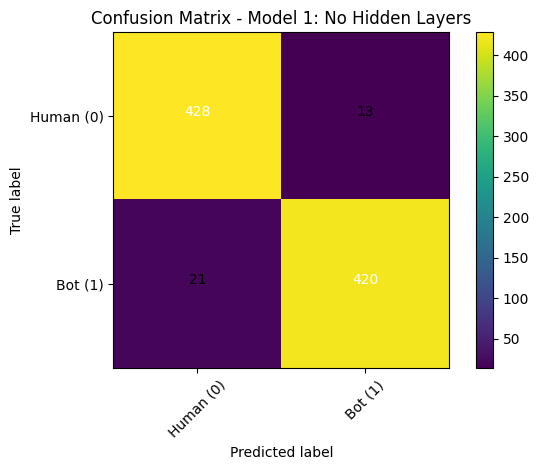

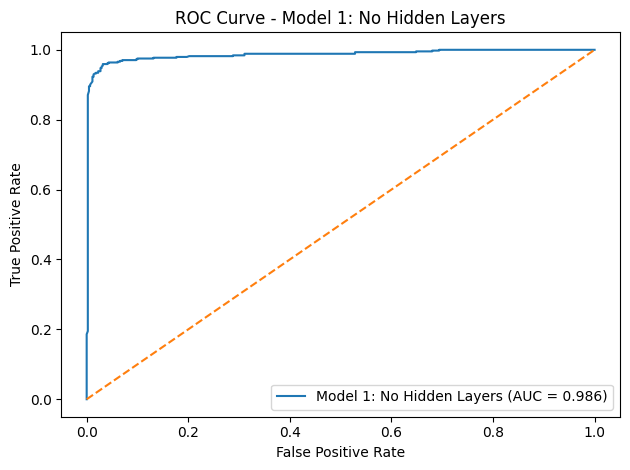

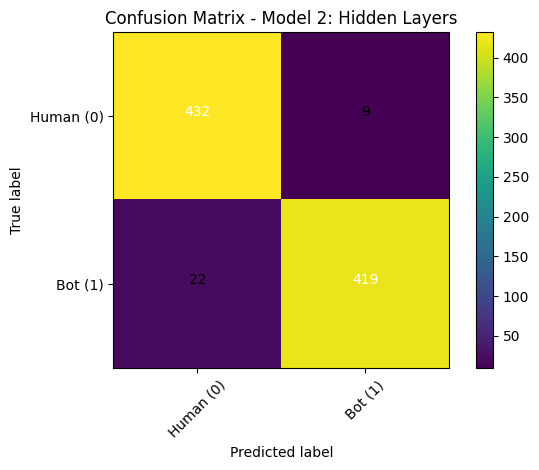

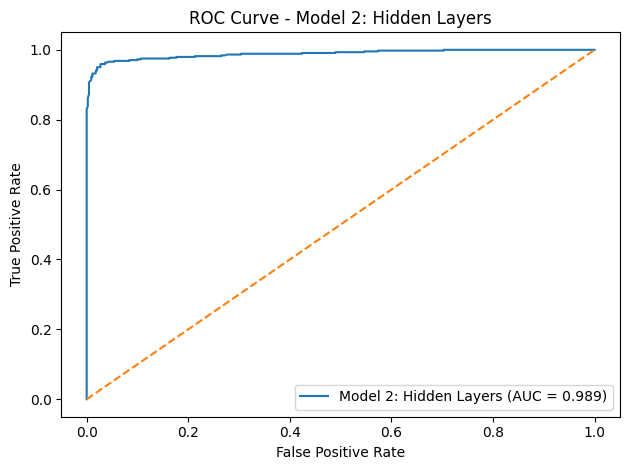

In [1]:
import pandas as pd
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import data_module
"""
README:

2 model variants are trained and tested in this program.

1. Simple NN with no hidden layers
2. Complex NN with 2 hidden layers
"""


def plot_confusion_matrix(cm, model_name):
    """Plot a 2x2 confusion matrix."""
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.colorbar()
    tick_marks = np.arange(2)
    classes = ["Human (0)", "Bot (1)"]
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #Write counts on the matrix
    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            plt.text(
                j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()


"""
Run evaluation on test set:
- Confusion matrix
- Accuracy, Precision, Recall, F1, AUC
- ROC curve
"""
def evaluate_and_report(model, X_test, y_test, model_name):
    #Get predicted probabilities for the positive class
    y_proba = model.predict(X_test).ravel()

    #Convert probabilities to binary labels using 0.5 threshold
    y_pred = (y_proba >= 0.5).astype(int)

    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

    #Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    #ROC + AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()

    print(f"\n===== Test metrics for {model_name} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}")
    print(f"AUC      : {roc_auc:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": roc_auc,
        "confusion_matrix": cm,
    }

"""
Basic NN (No Hidden Layers)
- Input directly to output

"""

def build_model_1(input_dim):

    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    return model

"""
NN with 2 Hidden Layers
- Two hidden layers with ReLU
- Dropout to help prevent overfitting
- Hidden Layer 1 with 64 nodes
- Hidden Layer 2 with 32 nodes
"""

def build_model_2(input_dim):

    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    return model



df = data_module.load_data()
X, y, preprocessor = data_module.preprocess(df)
X_train, y_train, X_val, y_val, X_test, y_test = data_module.split(X, y, preprocessor)


SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


n_samples, n_features = X.shape
print(f"Samples: {n_samples}, Features: {n_features}")



"""
#For Debug
print(f"Train size: {X_train.shape[0]}")
print(f"Val size:   {X_val.shape[0]}")
print(f"Test size:  {X_test.shape[0]}")

"""

#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

n_features = X_train_scaled.shape[1]




early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

#Training Factors
EPOCHS = 50
BATCH_SIZE = 64

results_summary = {}

#Model 1
model1 = build_model_1(n_features)
model1.summary()

start_time = time.time()
history1 = model1.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1,
)
time_model1 = time.time() - start_time
print(f"Training time (Model 1): {time_model1:.2f} seconds")

metrics1 = evaluate_and_report(model1, X_test_scaled, y_test, "Model 1: No Hidden Layers")
metrics1["training_time_sec"] = time_model1
results_summary["Model 1"] = metrics1

#Model 2
model2 = build_model_2(n_features)
model2.summary()

start_time = time.time()
history2 = model2.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1,
)
time_model2 = time.time() - start_time
print(f"Training time (Model 2): {time_model2:.2f} seconds")

metrics2 = evaluate_and_report(model2, X_test_scaled, y_test, "Model 2: Hidden Layers")
metrics2["training_time_sec"] = time_model2
results_summary["Model 2"] = metrics2

plt.show()

Correlation and Feature Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


df = pd.read_csv('bots_vs_users.csv')
df_num = df.select_dtypes(include=[np.number])
corr = df_num.corr()

# Analysis of numeric features
#Check for leakage by using correlation matrix and eliminating abnormally high correlations (>=0.7)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar=True
)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


X = df.drop(columns=['target'])
y = df['target']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
plot_df = X_train.copy()
plot_df['target'] = y_train

cat_cols = plot_df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=plot_df, x=col, hue='target')
    plt.title(f"Distribution of '{col}' by Target")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()